In [2]:
#importation des librairies nécessaires
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pylab 
import scipy.stats as stats
from pandas_profiling import ProfileReport
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.metrics import accuracy_score,roc_curve, auc,classification_report,confusion_matrix,roc_auc_score
#Importaion du MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn import metrics

In [3]:
#chargement des donnees csv
df = pd.read_csv('dataset/WA_Fn-UseC_-Telco-Customer-Churn.csv')

# DATA UNDERSTANDING

In [3]:
profile = ProfileReport(df, title='Pandas Profiling Report', html={'style':{'full_width':True}})
profile

# Data cleaning

In [208]:
#Découvrir les cases vides de la colonne TotalCharges
df.query("TotalCharges == ' '").TotalCharges.count()

11

In [209]:
#Remplacer les 11 espaces de valeurs manquantes par nan
df["TotalCharges"] = df["TotalCharges"].replace(' ',np.nan)

In [210]:
#Changer le type de la variable TotalCharges
df.TotalCharges=df.TotalCharges.astype('float64') 

In [211]:
#afficher le type de la variable TotalCharges
df.TotalCharges.dtypes

dtype('float64')

In [212]:
#Supprimer les valeurs manquantes 
df.dropna(inplace = True);

### Data preprocessing

In [213]:
#Selection des variables catégorielles
Categorial_columns = [col for col in df.columns if col not in ("customerID","MonthlyCharges","TotalCharges","tenure","Churn")]

In [214]:
#Pour éviter la redondances il faut considerer "No internet service"  comme "no"
for col in Categorial_columns:
    if col in ("OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport","StreamingTV","StreamingMovies"):
        df[col] = df[col].replace({'No internet service':'No'})

## Limites

Les classifieurs naïfs bayésiens certes sont populaires à cause de leur simplicité.
Mais, une telle simplicité vient avec un cout.

- Les probabilités obtenues en utilisant ces classifieurs ne doivent pas être prises au sérieux.
- S'il existe une grande corrélation entre les caractéristiques, ils vont donner une mauvaise performance.
- Dans le cas des caractéristiques continues (prix, surface, etc.), les données doivent suivre la loi normale.

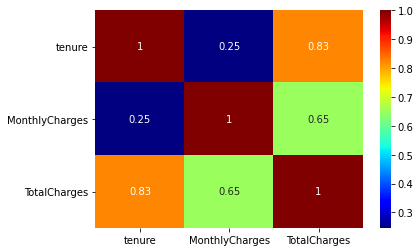

In [186]:
#Afficher la matrice du corrélation entre les varaibles numériques
splot=sns.heatmap(df[["tenure","MonthlyCharges","TotalCharges"]].corr(),annot=True,cmap='jet');
#enrigistrement de la figure 
splot.figure.savefig('figure8.png', dpi = 400)

- Nous supprimons TotalCharges car il est fortement corrélé avec les varaibles "MonthlyCharges" et "tenure" . 

In [215]:
df_new = df.drop(columns = ['TotalCharges'])

/home/ayadi/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


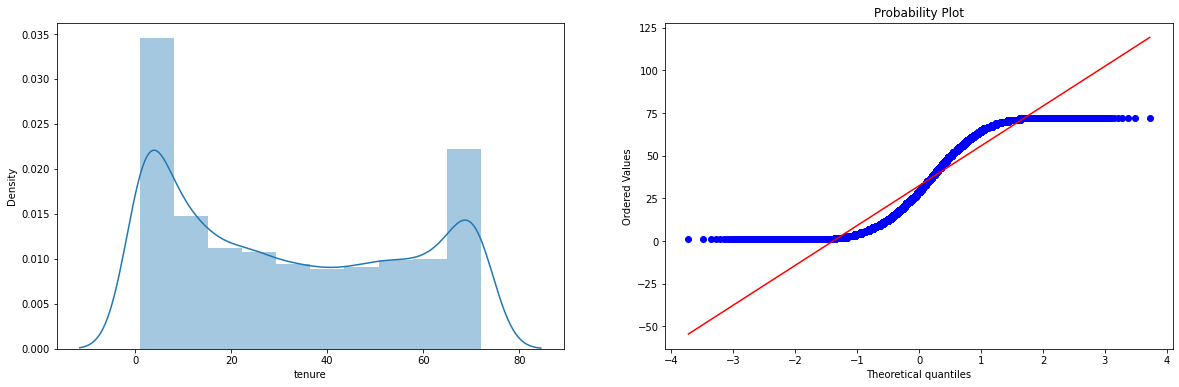

In [216]:
f, axes = plt.subplots( ncols=2, figsize=(20, 6))
stats.probplot(df_new["tenure"], dist="norm", plot=pylab);
sns.distplot(df_new['tenure'], bins=10,ax=axes[0]);

- À partir de l'histogramme de "Tenure", nous pouvons voir qu'un grand nombre de clients ne sont dans l'entreprise
que depuis moins de 5 mois. Cela signifie qu'ils sont des clients relativement nouveaux. 
Il y a également un nombre important de clients qui sont dans l'entreprise depuis plus de 65 mois. 

/home/ayadi/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


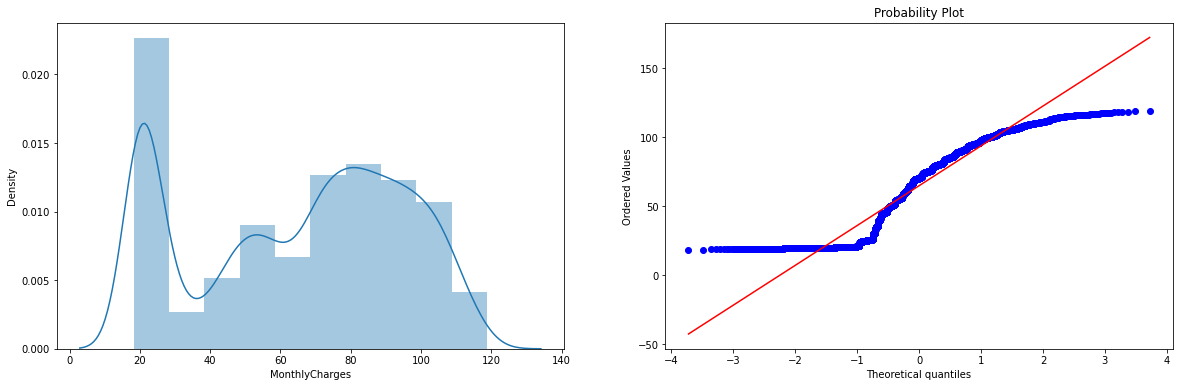

In [217]:
f, axes = plt.subplots( ncols=2, figsize=(20, 6))
stats.probplot(df_new["MonthlyCharges"], dist="norm", plot=pylab);
sns.distplot(df_new['MonthlyCharges'], bins=10,ax=axes[0]);

- D'après l'histogramme de MonthlyCharges, il semble y avoir deux groupes de clients. Le premier groupe a des frais 
mensuels d'environ 20 à 25 tandis que le second groupe a des frais mensuels d'environ 75 à 95.

D'après les histogrammes, il apparaît que les variables ne suivent pas une distribution normale. Deplus, il y a trop de points qui s'éloignent trop de la ligne, ce qui est une hypothèse de Bayes Classifier naïf.


# Conversion des varible numriques en variables catégorielles

In [218]:
#Diviser la varaible Tenure en groupes  
def tenure_to_group(df_new):
    if df_new["tenure"] <=12: # represente entre 0 et 12 moins 
        return "0_1_year"
    elif (df_new["tenure"] > 12) & (df_new["tenure"] <= 24 ): # represente entre 1 et 2 ans 
        return "1_2_year"
    elif (df_new["tenure"] > 24) & (df_new["tenure"] <= 36) : # represente entre 2 et 3 ans
        return "2_3_year"
    elif (df_new["tenure"] > 36) & (df_new["tenure"] <= 48) : # represente entre 3 et 4 ans
        return "3_4_year"
    elif (df_new["tenure"] > 48) & (df_new["tenure"] <= 60): # represente entre 4 et 5 ans
        return "4_5_year"
    elif (df_new["tenure"] > 60) & (df_new["tenure"] <= 72): # represente entre 5 et 6 ans
        return "5_6_year"
df_new["Tenure_Group"] = df_new.apply(lambda df_new:tenure_to_group(df_new),axis = 1) # ajouter dans la dataframe

In [220]:
max(df_new["MonthlyCharges"])

118.75

In [221]:
#Diviser la varaible MonthlyCharges en groupes  
def MonthlyCharges_to_group(df_new):
    if df_new["MonthlyCharges"] <=27.675: # represente entre 0 et 27 
        return "0_27_Charges"
    elif (df_new["MonthlyCharges"] > 27.675) & (df_new["tenure"] <= 68.825 ): # represente entre 27 et 67 
        return "27_68_Charges"
    elif (df_new["MonthlyCharges"] > 60) & (df_new["tenure"] <= 118.75): # represente entre 60 et 118
        return "68_118_Charges"
df_new["MonthlyCharges_Group"] = df_new.apply(lambda df_new:MonthlyCharges_to_group(df_new),axis = 1) # ajouter dans la dataframe

In [222]:
#Supprimer la colonne "customerID" de la table (non nécessaire pour la prédection)
df_new = df_new.drop(columns = ['customerID','tenure','MonthlyCharges'])

In [223]:
#Afficher les modalités de chaques varaibles
for col in df_new.columns:
    print("{} : {}".format(col,df_new[col].unique()))

gender : ['Female' 'Male']
SeniorCitizen : [0 1]
Partner : ['Yes' 'No']
Dependents : ['No' 'Yes']
PhoneService : ['No' 'Yes']
MultipleLines : ['No phone service' 'No' 'Yes']
InternetService : ['DSL' 'Fiber optic' 'No']
OnlineSecurity : ['No' 'Yes']
OnlineBackup : ['Yes' 'No']
DeviceProtection : ['No' 'Yes']
TechSupport : ['No' 'Yes']
StreamingTV : ['No' 'Yes']
StreamingMovies : ['No' 'Yes']
Contract : ['Month-to-month' 'One year' 'Two year']
PaperlessBilling : ['Yes' 'No']
PaymentMethod : ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn : ['No' 'Yes']
Tenure_Group : ['0_1_year' '2_3_year' '3_4_year' '1_2_year' '5_6_year' '4_5_year']
MonthlyCharges_Group : ['27_68_Charges' '0_27_Charges' '68_118_Charges' None]


In [224]:
#Encodage des varaibles catégorielles avec factorize si on a deux modalités ou get_dummies  pour plus que deux
for col in df_new.select_dtypes(include=[object]).columns:
    if df_new[col].nunique() == 2:
        df_new[col], _ = pd.factorize(df_new[col])
    else:
        df_new = pd.get_dummies(df_new, columns=[col],drop_first=True)

In [225]:
df_new.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'Churn',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_Fiber optic', 'InternetService_No',
       'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'Tenure_Group_1_2_year', 'Tenure_Group_2_3_year',
       'Tenure_Group_3_4_year', 'Tenure_Group_4_5_year',
       'Tenure_Group_5_6_year', 'MonthlyCharges_Group_27_68_Charges',
       'MonthlyCharges_Group_68_118_Charges'],
      dtype='object')

In [226]:
df_new=df_new[['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'PaperlessBilling',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_Fiber optic', 'InternetService_No',
       'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'Tenure_Group_1_2_year', 'Tenure_Group_2_3_year',
       'Tenure_Group_3_4_year', 'Tenure_Group_4_5_year',
       'Tenure_Group_5_6_year', 'MonthlyCharges_Group_27_68_Charges',
       'MonthlyCharges_Group_68_118_Charges','Churn']]

# Modélisation

In [227]:
#Partition de la dataframe en une variable à expliquer et des variable explicatives
X= df_new.iloc[:,0:28]
y= df_new.iloc[:,28]

In [228]:
#Diviser les données (70% Apprentissage et 30% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=0)

In [229]:
nb = {'gaussian': GaussianNB(),
      'bernoulli': BernoulliNB(),
      'multinomial': MultinomialNB()}
scores = {}
for key, model in nb.items():
    s = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    scores[key] = np.mean(s)
scores

{'gaussian': 0.7200315711278941,
 'bernoulli': 0.7649312863687012,
 'multinomial': 0.7767176344352276}

In [230]:
Nb = GaussianNB()
Nb_model = Nb.fit(X_train, y_train)
y_pred_Nb = Nb_model.predict(X_test)

In [231]:
Bnb = BernoulliNB()
Bnb = Bnb.fit(X_train, y_train)
y_pred_Bnb = Bnb.predict(X_test)

In [232]:
Mnb = MultinomialNB()
Mnb = Mnb.fit(X_train, y_train)
y_pred_Mnb = Mnb.predict(X_test)

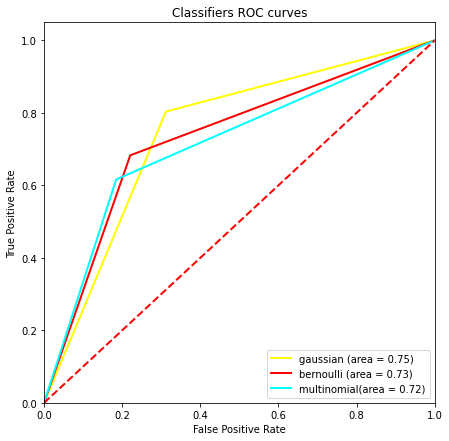

In [233]:
fpr1, tpr1, threshold1 = roc_curve(y_test, y_pred_Nb) 
roc_auc1 = auc(fpr1, tpr1)
fpr2, tpr2, threshold2 = roc_curve(y_test, y_pred_Bnb) 
roc_auc2 = auc(fpr2, tpr2)
fpr3, tpr3, threshold3 = roc_curve(y_test, y_pred_Mnb)
roc_auc3 = auc(fpr3, tpr3)
plt.figure(figsize=(7,7)) 
plt.plot(fpr1, tpr1, color='yellow', lw=2, label='gaussian (area = %0.2f)'% roc_auc1)
plt.plot(fpr2, tpr2, color='red', lw=2, label='bernoulli (area = %0.2f)'% roc_auc2)
plt.plot(fpr3, tpr3, color='cyan', lw=2, label='multinomial(area = %0.2f)'% roc_auc3)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--') 
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.05]) 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.title('Classifiers ROC curves') 
plt.legend(loc = "lower right")
plt.show()

- modele à retenir GaussianNB

In [234]:
print('Accuracy of Nb classifier on training set: {:.2f}'
     .format(Nb.score(X_train, y_train)))
print('Accuracy of Nb classifier on test set: {:.2f}'
     .format(Nb.score(X_test, y_test)))

Accuracy of Nb classifier on training set: 0.72
Accuracy of Nb classifier on test set: 0.72


In [235]:
# calculate roc auc
NB_roc_auc = roc_auc_score(y_test, y_pred_Nb)
NB_roc_auc

0.7458532487471394

In [104]:
NB_accuracy_score=accuracy_score(y_test, y_pred_Nb)
NB_accuracy_score

0.7184834123222749

In [105]:
print(classification_report(y_test, y_pred_Nb))

              precision    recall  f1-score   support

           0       0.91      0.69      0.78      1555
           1       0.48      0.80      0.60       555

    accuracy                           0.72      2110
   macro avg       0.69      0.75      0.69      2110
weighted avg       0.79      0.72      0.73      2110



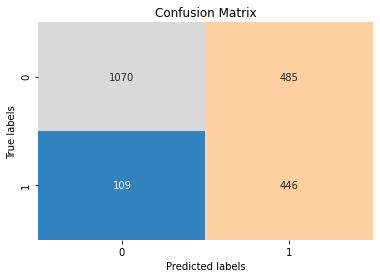

In [106]:
conf_mtx = confusion_matrix(y_test,y_pred_Nb,labels=[0,1])
sns.heatmap(conf_mtx,annot=True,cmap='tab20c',cbar = False,fmt = "g")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix');
plt.savefig('figure10.png', dpi = 400)

# Sequential Backward Selection

<h3> Accuracy</h3>

In [32]:
# Sequential Backward Selection
#initiation de l'objet
gNB=GaussianNB()
#initialisation d'un tableau 
accuracySBS = []
i=1
for i in range(1,28):
    sbs = SFS(gNB, 
              k_features=i, 
              forward=False, 
              floating=False, 
              scoring='accuracy',
              cv=4,
              n_jobs=-1)
    sbs = sbs.fit(X, y)
    accuracySBS.append(sbs.k_score_)

<h3> Roc_auc</h3>

In [33]:
# Sequential Backward Selection
gNB=GaussianNB()
roc_aucSBS = []
i=1
print()
for i in range(1,28):
    sbs = SFS(gNB, 
              k_features=i, 
              forward=False, 
              floating=False, 
              scoring='roc_auc',
              cv=4,
              n_jobs=-1)
    sbs = sbs.fit(X, y)
    roc_aucSBS.append(sbs.k_score_)

# Sequential Forward Selection


<h3> accuracy </h3>

In [34]:
# Sequential Forward Selection
gNB=GaussianNB()
accuracySFS = []
i=1
print()
for i in range(1,28):
    sfs = SFS(gNB, 
              k_features=i, 
              forward=True, 
              floating=False, 
              scoring='accuracy',
              cv=4,
              n_jobs=-1)
    sfs = sfs.fit(X, y)
    accuracySFS.append(sfs.k_score_)


<h3> roc_auc </h3>

In [35]:
# Sequential Forward Selection
gNB=GaussianNB()
roc_aucSFS = []
i=1
print()
for i in range(1,28):
    sfs = SFS(gNB, 
              k_features=i, 
              forward=True, 
              floating=False, 
              scoring='roc_auc',
              cv=4,
              n_jobs=-1)
    sfs = sfs.fit(X, y)
    roc_aucSFS.append(sfs.k_score_)


# Sequential Floating Forward Selection


<h3> accuracy</h3>

In [36]:
# Sequential Floating Forward Selection
gNB=GaussianNB()
accuracySFFS = []
i=1
print()
for i in range(1,28):
    sffs = SFS(gNB, 
              k_features=i, 
              forward=True, 
              floating=True, 
              scoring='accuracy',
              cv=4,
              n_jobs=-1)
    sffs = sffs.fit(X, y)
    accuracySFFS.append(sffs.k_score_)

<h3> roc_auc</h3>

In [37]:
# Sequential Floating Forward Selection
gNB=GaussianNB()
roc_aucSFFS = []
i=1
print()
for i in range(1,28):
    sffs = SFS(gNB, 
              k_features=i, 
              forward=True, 
              floating=True, 
              scoring='roc_auc',
              cv=4,
              n_jobs=-1)
    sffs = sffs.fit(X, y)
    roc_aucSFFS.append(sffs.k_score_)

# Sequential Floating Backward Selection

<h3> accuracy </h3>

In [38]:
# Sequential Floating Backward Selection
gNB=GaussianNB()
accuracySFBS = []
i=1
print()
for i in range(1,28):
    sfbs = SFS(gNB, 
              k_features=i, 
              forward=False, 
              floating=True, 
              scoring='accuracy',
              cv=4,
              n_jobs=-1)
    sfbs = sfbs.fit(X, y)
    accuracySFBS.append(sfbs.k_score_)

<h3> roc_auc </h3>


In [39]:
# Sequential Floating Backward Selection
gNB=GaussianNB()
roc_aucSFBS = []
i=1
print()
for i in range(1,28):
    sfbs = SFS(gNB, 
              k_features=i, 
              forward=False, 
              floating=True, 
              scoring='roc_auc',
              cv=4,
              n_jobs=-1)
    sfbs = sfbs.fit(X, y)
    roc_aucSFBS.append(sfbs.k_score_)

# Evaluation

In [40]:
accuracyNB=[]
roc_aucNb=[]
for i in range(1,28):
    accuracyNB.append(NB_accuracy_score)
    roc_aucNb.append(NB_roc_auc)
    

# Tableau : Modèle de Performance 

In [175]:
models = pd.DataFrame({
    'kfeautres': np.arange(1,28),
    'Accuracy NB': accuracyNB,
    'AUC NB':roc_aucNb,
    'Accuracy SFS': accuracySFS,
    'AUC SFS':roc_aucSFS,
    'Accuracy SBS': accuracySBS,
    'AUC SBS':roc_aucSBS,
    'Accuracy SFFS': accuracySFFS,
    'AUC SFFS':roc_aucSFFS,
    'Accuracy SFBS': accuracySFBS,
    'AUC SFBS':roc_aucSFBS})

df2 = pd.DataFrame({
    'kfeautres': 'average',
    'Accuracy NB': models['Accuracy NB'].mean(),
    'AUC NB':models['AUC NB'].mean(),
    'Accuracy SFS': models['Accuracy SFS'].mean(),
    'AUC SFS':models['AUC SFS'].mean(),
    'Accuracy SBS': models['Accuracy SBS'].mean(),
    'AUC SBS':models['AUC SBS'].mean(),
    'Accuracy SFFS': models['Accuracy SFFS'].mean(),
    'AUC SFFS':models['AUC SFFS'].mean(),
    'Accuracy SFBS': models['Accuracy SFBS'].mean(),
    'AUC SFBS':models['AUC SFBS'].mean()
                     },index=[0])
df2.set_index('kfeautres', inplace=True)
models['Accuracy NB'] = pd.Series(["{0:.2f}%".format(val * 100) for val in models['Accuracy NB']], index = models.index)
models['Accuracy SFS'] = pd.Series(["{0:.2f}%".format(val * 100) for val in models['Accuracy SFS']], index = models.index)
models['Accuracy SBS'] = pd.Series(["{0:.2f}%".format(val * 100) for val in models['Accuracy SBS']], index = models.index)
models['Accuracy SFFS'] = pd.Series(["{0:.2f}%".format(val * 100) for val in models['Accuracy SFFS']], index = models.index)
models['Accuracy SFBS'] = pd.Series(["{0:.2f}%".format(val * 100) for val in models['Accuracy SFBS']], index = models.index)

df2['Accuracy NB'] = pd.Series(["{0:.2f}%".format(val * 100) for val in df2['Accuracy NB']], index = df2.index)
df2['Accuracy SFS'] = pd.Series(["{0:.2f}%".format(val * 100) for val in df2['Accuracy SFS']], index = df2.index)
df2['Accuracy SBS'] = pd.Series(["{0:.2f}%".format(val * 100) for val in df2['Accuracy SBS']], index = df2.index)
df2['Accuracy SFFS'] = pd.Series(["{0:.2f}%".format(val * 100) for val in df2['Accuracy SFFS']], index = df2.index)
df2['Accuracy SFBS'] = pd.Series(["{0:.2f}%".format(val * 100) for val in df2['Accuracy SFBS']], index = df2.index)



models.set_index('kfeautres', inplace=True)
models.sort_values(by="kfeautres",ascending=True)
display(models)
display(df2)

,Accuracy NB,AUC NB,Accuracy SFS,AUC SFS,Accuracy SBS,AUC SBS,Accuracy SFFS,AUC SFFS,Accuracy SFBS,AUC SFBS
kfeautres,,,,,,,,,,
1,71.85%,0.745853,73.42%,0.672759,73.42%,0.672759,73.42%,0.672759,73.42%,0.672759
2,71.85%,0.745853,73.42%,0.746365,72.99%,0.746365,73.42%,0.746365,73.42%,0.746365
3,71.85%,0.745853,73.73%,0.794263,75.78%,0.794263,73.73%,0.794263,75.82%,0.794263
4,71.85%,0.745853,74.89%,0.803404,77.36%,0.803404,74.89%,0.803404,77.49%,0.803404
5,71.85%,0.745853,76.38%,0.810110,76.72%,0.807163,76.38%,0.810110,75.55%,0.810110
6,71.85%,0.745853,76.38%,0.814284,77.70%,0.813018,76.38%,0.814284,76.65%,0.813018
7,71.85%,0.745853,75.97%,0.817113,77.72%,0.817820,75.97%,0.817113,76.83%,0.817820
8,71.85%,0.745853,76.35%,0.819027,77.74%,0.820632,77.47%,0.819027,76.81%,0.821962
9,71.85%,0.745853,76.27%,0.822886,77.01%,0.822364,76.86%,0.822886,75.71%,0.823469


,Accuracy NB,AUC NB,Accuracy SFS,AUC SFS,Accuracy SBS,AUC SBS,Accuracy SFFS,AUC SFFS,Accuracy SFBS,AUC SFBS
kfeautres,,,,,,,,,,
average,71.85%,0.745853,76.13%,0.81524,76.53%,0.815282,76.22%,0.815343,76.32%,0.815527


# Accuracy courbe

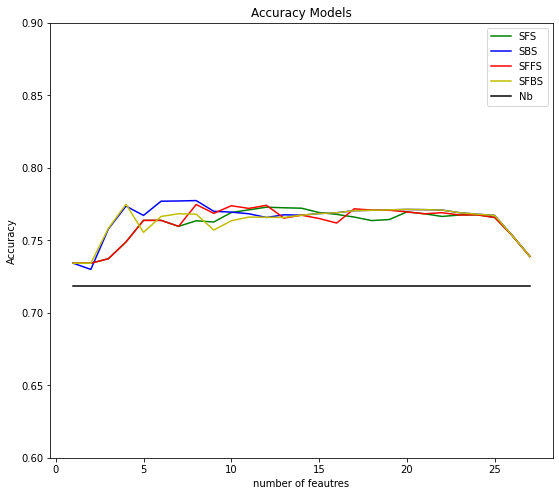

In [161]:

kfeautres = range(1,28)
plt.figure(figsize=(9,8)) #fixer la taille du figure
plt.plot(kfeautres, accuracySFS, 'g', label='SFS')
plt.plot(kfeautres, accuracySBS, 'b', label='SBS')
plt.plot(kfeautres, accuracySFFS, 'red', label='SFFS')
plt.plot(kfeautres, accuracySFBS, 'y', label='SFBS')
plt.plot(kfeautres, accuracyNB, 'black', label='Nb')

plt.title('Accuracy Models')
plt.xlabel('number of feautres')
plt.ylabel('Accuracy')
plt.ylim([0.6, 0.9])
plt.legend()
plt.show()

Courbe AUC

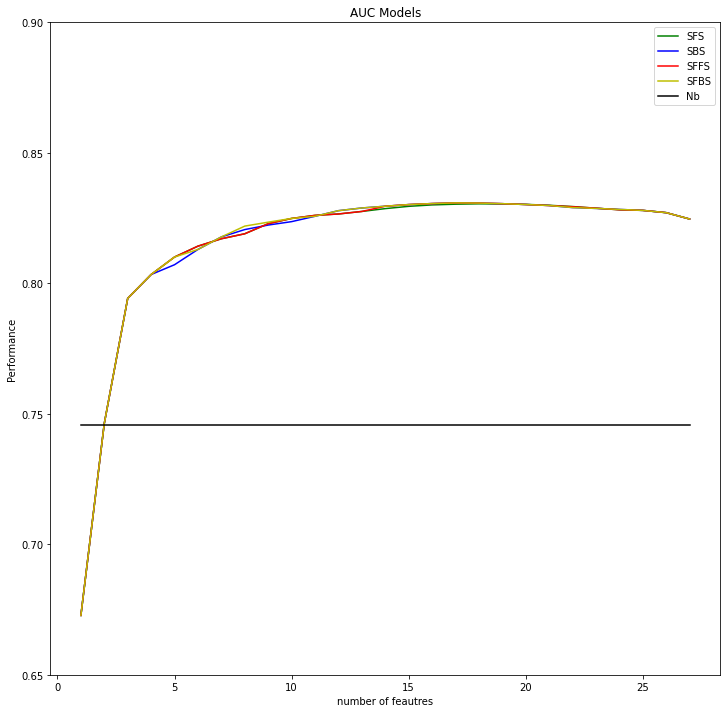

In [43]:

kfeautres = range(1,28)
plt.figure(figsize=(12,12)) #fixer la taille du figure
plt.plot(kfeautres, roc_aucSFS, 'g', label='SFS')
plt.plot(kfeautres, roc_aucSBS, 'b', label='SBS')
plt.plot(kfeautres, roc_aucSFFS, 'red', label='SFFS')
plt.plot(kfeautres, roc_aucSFBS, 'y', label='SFBS')
plt.plot(kfeautres, roc_aucNb, 'black', label='Nb')

plt.title('AUC Models')
plt.xlabel('number of feautres')
plt.ylabel('Performance')
plt.ylim([0.65, 0.9])

plt.legend()
plt.show()

In [121]:
# On va afficher un tableau qui ordonne les modèles du plus performant au moins performant suivant le score
s1=models["Aaccuracy NB"].max()
s2=models["Aaccuracy SFS"].max()
s3=models["Aaccuracy SBS"].max()
s4=models["Aaccuracy SFFS"].max()
s5=models["Aaccuracy SFBS"].max()

models_acc = pd.DataFrame({
    'Model': ['Aaccuracy NB', 'Aaccuracy SFS','Aaccuracy SBS',
              'Aaccuracy SFFS','Aaccuracy SFBS'],
    'Score': [s1,s2, s3,s4,s5]})
models_acc['Score'] = pd.Series(["{0:.2f}%".format(val * 100) for val in models_acc['Score']], index = models_acc.index)

models_acc.sort_values(by="Score",ascending=False)

,Model,Score
2,Aaccuracy SBS,77.74%
4,Aaccuracy SFBS,77.49%
3,Aaccuracy SFFS,77.47%
1,Aaccuracy SFS,77.29%
0,Aaccuracy NB,71.85%


In [124]:
# On va afficher un tableau qui ordonne les modèles du plus performant au moins performant suivant le score
s1=models["AUC NB"].max()
s2=models["AUC SFS"].max()
s3=models["AUC SBS"].max()
s4=models["AUC SFFS"].max()
s5=models["AUC SFBS"].max()

models_auc = pd.DataFrame({
    'Model': ['Aaccuracy NB', 'Aaccuracy SFS','Aaccuracy SBS',
              'Aaccuracy SFFS','Aaccuracy SFBS'],
    'roc_auc': [s1,s2, s3,s4,s5]})

models_auc.sort_values(by="roc_auc",ascending=False)

,Model,roc_auc
2,Aaccuracy SBS,0.830854
3,Aaccuracy SFFS,0.830854
4,Aaccuracy SFBS,0.830854
1,Aaccuracy SFS,0.830502
0,Aaccuracy NB,0.745853


# Normalisation des Donneés continues

 - On va maintenant essayer d'appliquer autre façon dont laquelle on normalise les variables quantitatives et on voit les différentes  résultats des algortihmes 

In [239]:
dataA = df.drop(columns = ['customerID'])

In [241]:
#Encodage des varaibles catégorielles avec factorize si on a deux modalités ou get_dummies  pour plus que deux
for col in dataA.select_dtypes(include=[object]).columns:
    if dataA[col].nunique() == 2:
        dataA[col], _ = pd.factorize(dataA[col])
    else:
        dataA = pd.get_dummies(dataA, columns=[col],drop_first=True)

In [247]:
num_cols=['MonthlyCharges','TotalCharges','tenure']

In [248]:
#Mettre les variables numériques dans une dataframe
Num_features= pd.DataFrame(data = dataA[num_cols])
Num_features.head()

,MonthlyCharges,TotalCharges,tenure
0,29.85,29.85,1
1,56.95,1889.50,34
2,53.85,108.15,2
3,42.30,1840.75,45
4,70.70,151.65,2


In [277]:
#instanciation de l'objet
sc = MinMaxScaler()
#transformation – centrage-réduction
Z = sc.fit_transform(Num_features)
print(Z)

[[0.11542289 0.0012751  0.        ]
 [0.38507463 0.21586661 0.46478873]
 [0.35422886 0.01031041 0.01408451]
 ...
 [0.11293532 0.03780868 0.14084507]
 [0.55870647 0.03321025 0.04225352]
 [0.86965174 0.78764136 0.91549296]]


In [278]:
Z_centre_df = pd.DataFrame(data = Z, columns=["tenure","MonthlyCharges","TotalCharges"], index=Num_features.index)

In [279]:
#Suppression des colonnes "MonthlyCharges","TotalCharges","tenure" du la dataframe
dataA.drop(["MonthlyCharges","TotalCharges","tenure"],axis = 1, inplace = True)
#Ajouter les nouveaux varaibles centrées réduites au dataframe
dataA = pd.concat([dataA, Z_centre_df], axis=1)

In [280]:
dataA.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'PaperlessBilling',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_Fiber optic', 'InternetService_No',
       'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check', 'Churn',
       'tenure', 'MonthlyCharges', 'TotalCharges'],
      dtype='object')

In [281]:
dataA=dataA[['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'PaperlessBilling',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_Fiber optic', 'InternetService_No',
       'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'tenure', 'MonthlyCharges', 'TotalCharges','Churn']]

In [282]:
#Partition de la dataframe en une variable à expliquer et des variable explicatives
X= dataA.iloc[:,0:24]
y= dataA.iloc[:,24]

In [283]:
#Diviser les données (70% Apprentissage et 30% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=0)

In [286]:
Nb = GaussianNB()
Nb_model = Nb.fit(X_train, y_train)
y_pred_Nb = Nb_model.predict(X_test)

In [287]:
print('Accuracy of Nb classifier on training set: {:.2f}'
     .format(Nb.score(X_train, y_train)))
print('Accuracy of Nb classifier on test set: {:.2f}'
     .format(Nb.score(X_test, y_test)))

Accuracy of Nb classifier on training set: 0.75
Accuracy of Nb classifier on test set: 0.75


In [288]:
# calculate roc auc
NB_roc_auc = roc_auc_score(y_test, y_pred_Nb)
NB_roc_auc

0.7531068045537499

In [289]:
NB_accuracy_score=accuracy_score(y_test, y_pred_Nb)
NB_accuracy_score

0.7488151658767772

In [300]:
# Sequential Backward Selection
gNB=GaussianNB()
sbs = SFS(gNB, 
          k_features=17, 
              forward=False, 
              floating=False, 
              scoring='accuracy',
              cv=4,
              n_jobs=-1)
sbs.fit(X, y)
sbs.k_score_

0.7821387940841866

# Sequential Backward Selection (SFS)

<h3> Accuracy</h3>

In [306]:
# Sequential Backward Selection
gNB=GaussianNB()
IaccuracySBS = []
i=1
print()
for i in range(1,24):
    sbs = SFS(gNB, 
              k_features=i, 
              forward=False, 
              floating=False, 
              scoring='accuracy',
              cv=4,
              n_jobs=-1)
    sbs = sbs.fit(X, y)
    IaccuracySBS.append(sbs.k_score_)
    

<h3> Roc_auc</h3>

In [307]:
 # Sequential Backward Selection
gNB=GaussianNB()
Iroc_aucSBS = []
i=1
print()
for i in range(1,24):
    sbs = SFS(gNB, 
              k_features=i, 
              forward=False, 
              floating=False, 
              scoring='roc_auc',
              cv=4,
              n_jobs=-1)
    sbs = sbs.fit(X, y)
    Iroc_aucSBS.append(sbs.k_score_)

# Sequential Forward Selection (SFS)

<h3> accuracy </h3>    

In [308]:
# Sequential Forward Selection
gNB=GaussianNB()
IaccuracySFS = []
i=1
print()
for i in range(1,24):
    sfs = SFS(gNB, 
              k_features=i, 
              forward=True, 
              floating=False, 
              scoring='accuracy',
              cv=4,
              n_jobs=-1)
    sfs = sfs.fit(X, y)
    IaccuracySFS.append(sfs.k_score_)
    

<h3> roc_auc </h3>

In [309]:
# Sequential Forward Selection
gNB=GaussianNB()
Iroc_aucSFS = []
i=1
print()
for i in range(1,24):
    sfs = SFS(gNB, 
              k_features=i, 
              forward=True, 
              floating=False, 
              scoring='roc_auc',
              cv=4,
              n_jobs=-1)
    sfs = sfs.fit(X, y)
    Iroc_aucSFS.append(sfs.k_score_)   
    

# Sequential Floating Forward Selection (SFFS)

<h3> accuracy</h3>   

In [310]:
# Sequential Floating Forward Selection
gNB=GaussianNB()
IaccuracySFFS = []
i=1
print()
for i in range(1,24):
    sffs = SFS(gNB, 
              k_features=i, 
              forward=True, 
              floating=True, 
              scoring='accuracy',
              cv=4,
              n_jobs=-1)
    sffs = sffs.fit(X, y)
    IaccuracySFFS.append(sffs.k_score_) 

 <h3> roc_auc</h3>

In [311]:
# Sequential Floating Forward Selection


gNB=GaussianNB()
Iroc_aucSFFS = []
i=1
print()
for i in range(1,24):
    sffs = SFS(gNB, 
              k_features=i, 
              forward=True, 
              floating=True, 
              scoring='roc_auc',
              cv=4,
              n_jobs=-1)
    sffs = sffs.fit(X, y)
    Iroc_aucSFFS.append(sffs.k_score_)
    

 # Sequential Floating Backward Selection (SFBS)   

 <h3> accuracy </h3>

In [312]:
 # Sequential Floating Backward Selection
gNB=GaussianNB()
IaccuracySFBS = []
i=1
print()
for i in range(1,24):
    sfbs = SFS(gNB, 
              k_features=i, 
              forward=False, 
              floating=True, 
              scoring='accuracy',
              cv=4,
              n_jobs=-1)
    sfbs = sfbs.fit(X, y)
    IaccuracySFBS.append(sfbs.k_score_)

 <h3> roc_auc </h3>

In [313]:
 # Sequential Floating Backward Selection


gNB=GaussianNB()
Iroc_aucSFBS = []
i=1
print()
for i in range(1,24):
    sfbs = SFS(gNB, 
              k_features=i, 
              forward=False, 
              floating=True, 
              scoring='roc_auc',
              cv=4,
              n_jobs=-1)
    sfbs = sfbs.fit(X, y)
    Iroc_aucSFBS.append(sfbs.k_score_)

In [338]:
IaccuracyNB=[]
Iroc_aucNb=[]
for i in range(1,24):
    IaccuracyNB.append(NB_accuracy_score)
    Iroc_aucNb.append(NB_roc_auc)

# Tableau : Modèle de Performance (Min Max Scaler )

In [347]:
models2 = pd.DataFrame({
    'kfeautres': np.arange(1,24),
    'Accuracy NB': IaccuracyNB,
    'AUC NB':Iroc_aucNb,
    'Accuracy SFS': IaccuracySFS,
    'AUC SFS':Iroc_aucSFS,
    'Accuracy SBS': IaccuracySBS,
    'AUC SBS':Iroc_aucSBS,
    'Accuracy SFFS': IaccuracySFFS,
    'AUC SFFS':Iroc_aucSFFS,
    'Accuracy SFBS': IaccuracySFBS,
    'AUC SFBS':Iroc_aucSFBS})

dfv2 = pd.DataFrame({
    'kfeautres': 'average',
    'Accuracy NB': models2['Accuracy NB'].mean(),
    'AUC NB':models2['AUC NB'].mean(),
    'Accuracy SFS': models2['Accuracy SFS'].mean(),
    'AUC SFS':models2['AUC SFS'].mean(),
    'Accuracy SBS': models2['Accuracy SBS'].mean(),
    'AUC SBS':models2['AUC SBS'].mean(),
    'Accuracy SFFS': models2['Accuracy SFFS'].mean(),
    'AUC SFFS':models2['AUC SFFS'].mean(),
    'Accuracy SFBS': models2['Accuracy SFBS'].mean(),
    'AUC SFBS':models2['AUC SFBS'].mean()
                     },index=[0])
dfv2.set_index('kfeautres', inplace=True)


models2['Accuracy NB'] = pd.Series(["{0:.2f}%".format(val * 100) for val in models2['Accuracy NB']], index = models2.index)
models2['Accuracy SFS'] = pd.Series(["{0:.2f}%".format(val * 100) for val in models2['Accuracy SFS']], index = models2.index)
models2['Accuracy SBS'] = pd.Series(["{0:.2f}%".format(val * 100) for val in models2['Accuracy SBS']], index = models2.index)
models2['Accuracy SFFS'] = pd.Series(["{0:.2f}%".format(val * 100) for val in models2['Accuracy SFFS']], index = models2.index)
models2['Accuracy SFBS'] = pd.Series(["{0:.2f}%".format(val * 100) for val in models2['Accuracy SFBS']], index = models2.index)

dfv2['Accuracy NB'] = pd.Series(["{0:.2f}%".format(val * 100) for val in dfv2['Accuracy NB']], index = dfv2.index)
dfv2['Accuracy SFS'] = pd.Series(["{0:.2f}%".format(val * 100) for val in dfv2['Accuracy SFS']], index = dfv2.index)
dfv2['Accuracy SBS'] = pd.Series(["{0:.2f}%".format(val * 100) for val in dfv2['Accuracy SBS']], index = dfv2.index)
dfv2['Accuracy SFFS'] = pd.Series(["{0:.2f}%".format(val * 100) for val in dfv2['Accuracy SFFS']], index = dfv2.index)
dfv2['Accuracy SFBS'] = pd.Series(["{0:.2f}%".format(val * 100) for val in dfv2['Accuracy SFBS']], index = dfv2.index)

models2.set_index('kfeautres', inplace=True)
models2.sort_values(by="kfeautres",ascending=True)
display(models2)
display(dfv2)

,Accuracy NB,AUC NB,Accuracy SFS,AUC SFS,Accuracy SBS,AUC SBS,Accuracy SFFS,AUC SFFS,Accuracy SFBS,AUC SFBS
kfeautres,,,,,,,,,,
1,74.88%,0.753107,73.42%,0.741308,73.42%,0.741308,73.42%,0.741308,73.42%,0.741308
2,74.88%,0.753107,73.79%,0.808527,78.48%,0.808527,73.79%,0.808527,78.48%,0.808527
3,74.88%,0.753107,78.44%,0.817174,78.33%,0.817174,78.80%,0.817174,78.04%,0.817174
4,74.88%,0.753107,78.77%,0.825629,78.00%,0.825629,78.77%,0.825629,77.79%,0.825629
5,74.88%,0.753107,78.61%,0.828632,78.16%,0.828632,78.61%,0.828632,78.16%,0.828632
6,74.88%,0.753107,78.85%,0.830189,77.87%,0.830189,78.85%,0.830189,78.00%,0.830189
7,74.88%,0.753107,78.65%,0.831148,78.07%,0.831148,78.65%,0.831148,78.20%,0.831148
8,74.88%,0.753107,78.67%,0.832801,78.07%,0.832801,78.67%,0.832801,78.36%,0.832801
9,74.88%,0.753107,78.67%,0.833582,78.31%,0.833582,78.67%,0.833582,78.30%,0.833582


,Accuracy NB,AUC NB,Accuracy SFS,AUC SFS,Accuracy SBS,AUC SBS,Accuracy SFFS,AUC SFFS,Accuracy SFBS,AUC SFBS
kfeautres,,,,,,,,,,
average,74.88%,0.753107,77.72%,0.826755,77.96%,0.82676,77.86%,0.826755,78.00%,0.82676
